<a href="https://colab.research.google.com/github/lubanabdis/skripsi-arsip/blob/main/source-code/pengujian-overfitting/bukti_UjiSkripsi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LOAD DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/buktiUji_Skripsi/Dataset'

Mounted at /content/drive


#IMPORT LIBRARY

In [ ]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold, StratifiedKFold
import pandas as pd
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import Input
from tensorflow.keras.layers import  MaxPooling2D, Dense, Dropout, Conv2D, MaxPool2D, Flatten, Reshape, BatchNormalization, Add, GlobalAveragePooling2D, ZeroPadding2D, AveragePooling2D, Activation
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision,SensitivityAtSpecificity, SpecificityAtSensitivity, Metric, TruePositives,FalseNegatives, Recall
from tensorflow.keras.models import load_model
from keras.models import load_model
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from tensorflow.python.keras.utils import metrics_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from google.colab import files
from keras.applications.vgg19 import preprocess_input
from sklearn.utils import shuffle, resample
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping, ModelCheckpoint,CSVLogger, ReduceLROnPlateau, LearningRateScheduler
import datetime
from sklearn.metrics import accuracy_score, classification_report
from keras import backend as K
import random
from sklearn.model_selection import train_test_split,  StratifiedShuffleSplit
!pip install pycm==3.1
%load_ext tensorboard
from pycm import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 595 kB 13.5 MB/s 


#LABELLING

In [ ]:
df = None
for label in os.listdir(data_dir):
  data = []
  for img_filename in os.listdir(data_dir + '/' + label):
    filename, ext = os.path.splitext(img_filename)
    label_folder = os.path.join(data_dir, label)
    src_img_filepath = os.path.join(label_folder, img_filename)
    data.append(src_img_filepath)
  new_df = pd.DataFrame(data, columns=['path',])
  new_df['label'] = label
  df = pd.concat([df, new_df])
df

,path,label
0,/content/drive/MyDrive/buktiUji_Skripsi/Datase...,normal
1,/content/drive/MyDrive/buktiUji_Skripsi/Datase...,normal
2,/content/drive/MyDrive/buktiUji_Skripsi/Datase...,normal
3,/content/drive/MyDrive/buktiUji_Skripsi/Datase...,normal
4,/content/drive/MyDrive/buktiUji_Skripsi/Datase...,normal
...,...,...
15,/content/drive/MyDrive/buktiUji_Skripsi/Datase...,monkeypox
16,/content/drive/MyDrive/buktiUji_Skripsi/Datase...,monkeypox
17,/content/drive/MyDrive/buktiUji_Skripsi/Datase...,monkeypox
18,/content/drive/MyDrive/buktiUji_Skripsi/Datase...,monkeypox


#SPLIT DATASET FOR CV

In [ ]:
df_train_val, df_test = train_test_split(df, random_state=666, test_size=0.1 )
df_train_val.to_csv('/content/drive/MyDrive/buktiUji_Skripsi/train_label.csv', index=False)
df_test.to_csv('/content/drive/MyDrive/buktiUji_Skripsi/test_label.csv', index=False)
image_size=(224, 224)

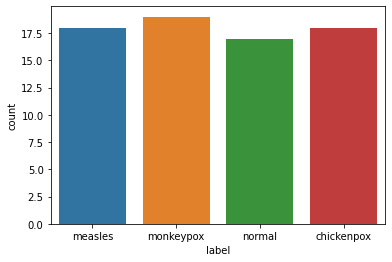

In [ ]:
ax = sns.countplot(x="label", data=df_train_val,)
plt.show()

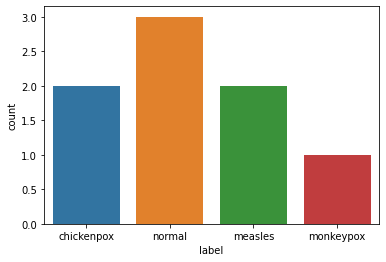

In [ ]:
ax = sns.countplot(x="label", data=df_test,)
plt.show()

#IMPORT MODEL

In [ ]:
model = keras.Sequential()

# Creating first block- (2 Convolution + 1 Max pool)
model.add(Conv2D(filters= 64, kernel_size= (3,3), strides= (1,1), padding='same', input_shape= (224, 224, 3), activation= 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters= 64, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size= (2,2), strides=(2,2)))

# Creating second block- (2 Convolution + 1 Max pool)
model.add(Conv2D(filters= 128, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters= 128, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size= (2,2), strides=(2,2)))

# Creating third block- (4 Convolution + 1 Max pool)
model.add(Conv2D(filters= 256, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters= 256, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters= 256, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters= 256, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size= (2,2), strides=(2,2)))

# Creating fourth block- (4 Convolution + 1 Max pool)
model.add(Conv2D(filters= 512, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters= 512, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters= 512, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters= 512, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size= (2,2), strides=(2,2)))

# Creating fifth block- (4 Convolution + 1 Max pool)
model.add(Conv2D(filters= 512, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters= 512, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters= 512, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters= 512, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size= (2,2), strides=(2,2)))

# Flattening the pooled image pixels
model.add(Flatten())

# Creating 2 Dense Layers
model.add(Dense(units= 4096, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units= 4096, activation='relu'))
model.add(Dropout(rate=0.5))

# Creating an output layer
model.add(Dense(units= 4, activation='softmax'))

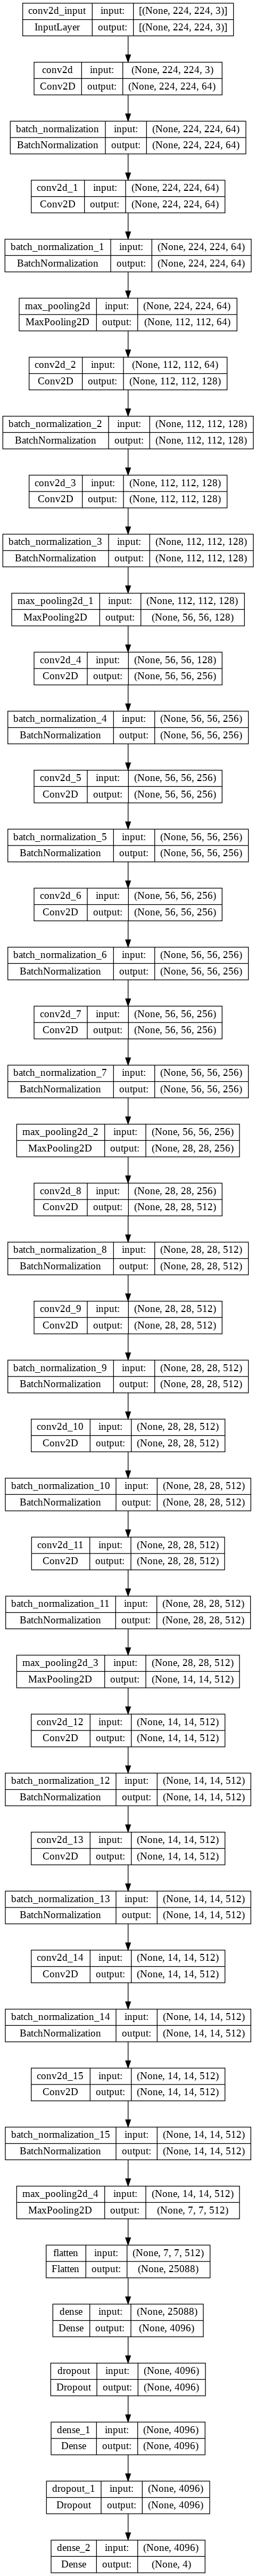

In [ ]:
plot_model(model = model, show_shapes = True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

#PROSES AUGMENTASI DATA

In [ ]:
datagen = ImageDataGenerator(rescale=1./255,)
train_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val, 
        x_col="path", 
        y_col="label", 
        shuffle=True, 
        target_size=(224,224),
        class_mode="categorical",) 

class_names = train_generator.class_indices
print(class_names)
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  # print(image_batch[0].shape)
  # zz.fit(image_batch)
  break

Found 72 validated image filenames belonging to 4 classes.
{'chickenpox': 0, 'measles': 1, 'monkeypox': 2, 'normal': 3}
(32, 224, 224, 3)
(32, 4)


#PELATIHAN MODEL

In [ ]:
def cross_validation_model_evaluate(model,  valData, i):
  val_datagen = ImageDataGenerator(rescale=1./255,)
  valData = df_train_val.iloc[val_index]
  val_generator = val_datagen.flow_from_dataframe(
        dataframe=valData,
        directory=data_dir,
        x_col="path",
        y_col="label",
        shuffle=False,
        target_size=image_size,
        class_mode="categorical", )

  Y_pred = model.predict(val_generator,)
  y_pred = np.argmax(Y_pred, axis=1)
  y_test = val_generator.classes
  cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred) 
  print(cm)
  eval_csv = '/content/drive/MyDrive/buktiUji_Skripsi/' +"Model/" + '_fold_' + str(i) + '_model.log'
  eval_csv = pd.read_csv(eval_csv, )
  plt.plot(eval_csv['accuracy'])
  plt.plot(eval_csv['loss'])
  plt.plot(eval_csv['val_accuracy'])
  plt.plot(eval_csv['val_loss'])
  plt.title('model performance')
  plt.ylabel('accuracy / loss')
  plt.xlabel('epoch')
  plt.legend(['train_accuracy', 'train_loss', 'val_accuracy', 'val_loss'], loc='upper left')
  plt.show()
  eval_csv = eval_csv[(eval_csv.val_accuracy == eval_csv.val_accuracy.max())]
  eval_csv = eval_csv[(eval_csv.val_loss== eval_csv.val_loss.min())]
  print(eval_csv)

#PENGUJIAN MODEL USING K-CV

##SKENARIO 1

In [ ]:
k = 10
kf =  StratifiedKFold(n_splits = k, shuffle = True, random_state = 666)
i = 1
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 1:
    print('Train shape:',df_train_val.iloc[train_index].shape)
    print('val shape:', df_train_val.iloc[val_index].shape)
    datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=30, 
                                  horizontal_flip=True, 
                                  zoom_range=[0.5,1.0],)

    csv_filepath = CSVLogger('/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.log')

    model_checkpoint_callback = ModelCheckpoint(
        filepath='/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.h5',
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True)
      
    csvlogger = csv_filepath
    callbacks = []
    callbacks.append(csvlogger)
    callbacks.append(model_checkpoint_callback)

    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[train_index], 
        x_col="path", 
        y_col="label", 
        shuffle=True, 
        target_size=(224,224),
        class_mode="categorical",) 
  
    val_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[val_index], 
        x_col="path", 
        y_col="label", 
        shuffle=False, 
        target_size=(224,224),
        class_mode="categorical",)
    optimizer = Adam(learning_rate=0.0001)  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    result = model.fit(x=train_generator,validation_data=val_generator, epochs=100, callbacks=callbacks )
    break
  i += 1

Train shape: (64, 2)
val shape: (8, 2)
Found 64 validated image filenames belonging to 4 classes.
Found 8 validated image filenames belonging to 4 classes.
Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 3.0708 - accuracy: 0.7188
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to /content/drive/MyDrive/buktiUji_Skripsi/Model/_fold_1_model.h5
2/2 [==============================] - 40s 35s/step - loss: 3.0708 - accuracy: 0.7188 - val_loss: 11.4822 - val_accuracy: 0.2500
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 3.2415 - accuracy: 0.7031
Epoch 2: val_accuracy did not improve from 0.25000
2/2 [==============================] - 2s 871ms/step - loss: 3.2415 - accuracy: 0.7031 - val_loss: 10.2730 - val_accuracy: 0.2500
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 2.3683 - accuracy: 0.7188
Epoch 3: val_accuracy did not improve from 0.25000
2/2 [==============================] - 2s 874ms/step - loss: 2.3683 - ac

###EVAL

Found 8 validated image filenames belonging to 4 classes.
1/1 [==============================] - 1s 501ms/step
Predict 0       1       2       3       
Actual
0       2       0       0       0       

1       1       0       1       0       

2       0       0       1       1       

3       0       0       0       2       





Overall Statistics : 

95% CI                                                            (0.28952,0.96048)
ACC Macro                                                         0.8125
ARI                                                               0.22222
AUNP                                                              0.75
AUNU                                                              0.75
Bangdiwala B                                                      0.5625
Bennett S                                                         0.5
CBA                                                               0.45833
CSI                                                     

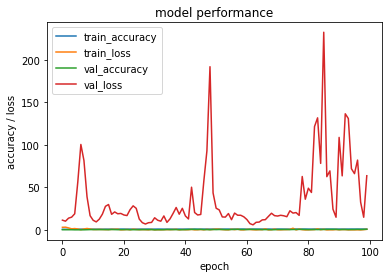

    epoch  accuracy      loss  val_accuracy   val_loss
99     99  0.953125  0.722035          0.75  63.736454


In [ ]:
n_splits = 10
kf =  StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 666)
i = 1
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 1:
    model_filepath = '/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.h5'
    model = load_model(model_filepath)
    cross_validation_model_evaluate(
      model,  df_train_val.iloc[val_index], i, 
       )
    break
  i += 1

##SKENARIO 2

In [ ]:
k = 10
kf =  StratifiedKFold(n_splits = k, shuffle = True, random_state = 666)
i = 1
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 2:
    print('Train shape:',df_train_val.iloc[train_index].shape)
    print('val shape:', df_train_val.iloc[val_index].shape)
    datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=30, 
                                  horizontal_flip=True, 
                                  zoom_range=[0.5,1.0],)

    csv_filepath = CSVLogger('/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.log')

    model_checkpoint_callback = ModelCheckpoint(
        filepath='/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.h5',
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True)
      
    csvlogger = csv_filepath
    callbacks = []
    callbacks.append(csvlogger)
    callbacks.append(model_checkpoint_callback)

    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[train_index], 
        x_col="path", 
        y_col="label", 
        shuffle=True, 
        target_size=(224,224),
        class_mode="categorical",) 
  
    val_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[val_index], 
        x_col="path", 
        y_col="label", 
        shuffle=False, 
        target_size=(224,224),
        class_mode="categorical",)
    optimizer = Adam(learning_rate=0.0001)  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    result = model.fit(x=train_generator,validation_data=val_generator, epochs=100, callbacks=callbacks )
    break
  i += 1

Train shape: (64, 2)
val shape: (8, 2)
Found 64 validated image filenames belonging to 4 classes.
Found 8 validated image filenames belonging to 4 classes.
Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 1.5198 - accuracy: 0.9375
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to /content/drive/MyDrive/buktiUji_Skripsi/Model/_fold_2_model.h5
2/2 [==============================] - 36s 33s/step - loss: 1.5198 - accuracy: 0.9375 - val_loss: 2.6180 - val_accuracy: 0.7500
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.9185 - accuracy: 0.9062
Epoch 2: val_accuracy did not improve from 0.75000
2/2 [==============================] - 2s 926ms/step - loss: 0.9185 - accuracy: 0.9062 - val_loss: 84.3120 - val_accuracy: 0.2500
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.7661 - accuracy: 0.8906
Epoch 3: val_accuracy did not improve from 0.75000
2/2 [==============================] - 2s 911ms/step - loss: 0.7661 - acc

###EVAL

Found 8 validated image filenames belonging to 4 classes.
1/1 [==============================] - 0s 374ms/step
Predict 0       1       2       3       
Actual
0       2       0       0       0       

1       1       1       0       0       

2       0       0       1       1       

3       0       0       0       2       





Overall Statistics : 

95% CI                                                            (0.44994,1.05006)
ACC Macro                                                         0.875
ARI                                                               0.27586
AUNP                                                              0.83333
AUNU                                                              0.83333
Bangdiwala B                                                      0.625
Bennett S                                                         0.66667
CBA                                                               0.58333
CSI                                             

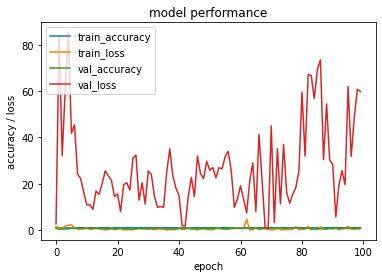

    epoch  accuracy     loss  val_accuracy  val_loss
69     69    0.9375  0.53249         0.875  0.390712


In [ ]:
n_splits = 10
kf =  StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 666)
i = 2
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 2:
    model_filepath = '/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.h5'
    model = load_model(model_filepath)
    cross_validation_model_evaluate(
      model,  df_train_val.iloc[val_index], i, 
       )
    break
  i += 1

##SKENARIO 3

In [ ]:
k = 10
kf =  StratifiedKFold(n_splits = k, shuffle = True, random_state = 666)
i = 1
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 3:
    print('Train shape:',df_train_val.iloc[train_index].shape)
    print('val shape:', df_train_val.iloc[val_index].shape)
    datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=30, 
                                  horizontal_flip=True, 
                                  zoom_range=[0.5,1.0],)

    csv_filepath = CSVLogger('/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.log')

    model_checkpoint_callback = ModelCheckpoint(
        filepath='/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.h5',
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True)
      
    csvlogger = csv_filepath
    callbacks = []
    callbacks.append(csvlogger)
    callbacks.append(model_checkpoint_callback)

    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[train_index], 
        x_col="path", 
        y_col="label", 
        shuffle=True, 
        target_size=(224,224),
        class_mode="categorical",) 
  
    val_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[val_index], 
        x_col="path", 
        y_col="label", 
        shuffle=False, 
        target_size=(224,224),
        class_mode="categorical",)
    optimizer = Adam(learning_rate=0.0001)  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    result = model.fit(x=train_generator,validation_data=val_generator, epochs=100, callbacks=callbacks )
    break
  i += 1

Train shape: (65, 2)
val shape: (7, 2)
Found 65 validated image filenames belonging to 4 classes.
Found 7 validated image filenames belonging to 4 classes.
Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 1.5110 - accuracy: 0.9077
Epoch 1: val_accuracy improved from -inf to 0.85714, saving model to /content/drive/MyDrive/buktiUji_Skripsi/Model/_fold_3_model.h5
3/3 [==============================] - 42s 19s/step - loss: 1.5110 - accuracy: 0.9077 - val_loss: 5.9280 - val_accuracy: 0.8571
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 1.6387 - accuracy: 0.8769
Epoch 2: val_accuracy did not improve from 0.85714
3/3 [==============================] - 2s 633ms/step - loss: 1.6387 - accuracy: 0.8769 - val_loss: 5.9821 - val_accuracy: 0.8571
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 1.1489 - accuracy: 0.8769
Epoch 3: val_accuracy did not improve from 0.85714
3/3 [==============================] - 2s 489ms/step - loss: 1.1489 - accu

###EVAL

Found 8 validated image filenames belonging to 4 classes.
1/1 [==============================] - 0s 344ms/step
Predict 0       1       2       3       
Actual
0       0       1       0       1       

1       0       2       0       0       

2       0       0       1       1       

3       0       0       0       2       





Overall Statistics : 

95% CI                                                            (0.28952,0.96048)
ACC Macro                                                         0.8125
ARI                                                               0.13699
AUNP                                                              0.75
AUNU                                                              0.75
Bangdiwala B                                                      0.5625
Bennett S                                                         0.5
CBA                                                               0.41667
CSI                                                     

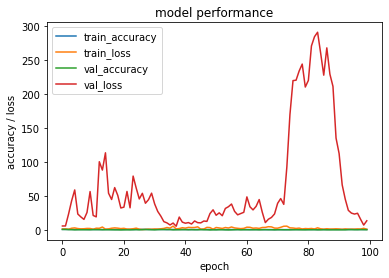

   epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.907692  1.510977      0.857143  5.927969


In [ ]:
n_splits = 10
kf =  StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 666)
i = 3
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 3:
    model_filepath = '/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.h5'
    model = load_model(model_filepath)
    cross_validation_model_evaluate(
      model,  df_train_val.iloc[val_index], i, 
       )
    break
  i += 1

##SKENARIO 4

In [ ]:
k = 10
kf =  StratifiedKFold(n_splits = k, shuffle = True, random_state = 666)
i = 1
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 4:
    print('Train shape:',df_train_val.iloc[train_index].shape)
    print('val shape:', df_train_val.iloc[val_index].shape)
    datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=30, 
                                  horizontal_flip=True, 
                                  zoom_range=[0.5,1.0],)

    csv_filepath = CSVLogger('/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.log')

    model_checkpoint_callback = ModelCheckpoint(
        filepath='/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.h5',
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True)
      
    csvlogger = csv_filepath
    callbacks = []
    callbacks.append(csvlogger)
    callbacks.append(model_checkpoint_callback)

    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[train_index], 
        x_col="path", 
        y_col="label", 
        shuffle=True, 
        target_size=(224,224),
        class_mode="categorical",) 
  
    val_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[val_index], 
        x_col="path", 
        y_col="label", 
        shuffle=False, 
        target_size=(224,224),
        class_mode="categorical",)
    optimizer = Adam(learning_rate=0.0001)  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    result = model.fit(x=train_generator,validation_data=val_generator, epochs=100, callbacks=callbacks )
    break
  i += 1

Train shape: (65, 2)
val shape: (7, 2)
Found 65 validated image filenames belonging to 4 classes.
Found 7 validated image filenames belonging to 4 classes.
Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 1.6942 - accuracy: 0.8769
Epoch 1: val_accuracy improved from -inf to 0.57143, saving model to /content/drive/MyDrive/buktiUji_Skripsi/Model/_fold_4_model.h5
3/3 [==============================] - 38s 18s/step - loss: 1.6942 - accuracy: 0.8769 - val_loss: 41.6403 - val_accuracy: 0.5714
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.6258 - accuracy: 0.9385
Epoch 2: val_accuracy did not improve from 0.57143
3/3 [==============================] - 2s 447ms/step - loss: 0.6258 - accuracy: 0.9385 - val_loss: 35.5438 - val_accuracy: 0.4286
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 1.8698 - accuracy: 0.8462
Epoch 3: val_accuracy did not improve from 0.57143
3/3 [==============================] - 2s 1s/step - loss: 1.8698 - accur

###EVAL

Found 8 validated image filenames belonging to 4 classes.
1/1 [==============================] - 0s 466ms/step
Predict 0       1       2       3       
Actual
0       1       0       1       0       

1       1       1       0       0       

2       0       0       2       0       

3       0       0       0       2       





Overall Statistics : 

95% CI                                                            (0.44994,1.05006)
ACC Macro                                                         0.875
ARI                                                               0.33962
AUNP                                                              0.83333
AUNU                                                              0.83333
Bangdiwala B                                                      0.625
Bennett S                                                         0.66667
CBA                                                               0.66667
CSI                                             

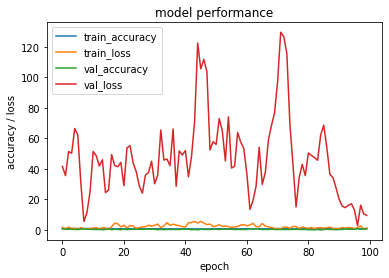

    epoch  accuracy      loss  val_accuracy  val_loss
96     96  0.784615  1.455903      0.857143  2.806266


In [ ]:
n_splits = 10
kf =  StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 666)
i = 4
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 4:
    model_filepath = '/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.h5'
    model = load_model(model_filepath)
    cross_validation_model_evaluate(
      model,  df_train_val.iloc[val_index], i, 
       )
    break
  i += 1

##SKENARIO 5

In [ ]:
k = 10
kf =  StratifiedKFold(n_splits = k, shuffle = True, random_state = 666)
i = 1
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 5:
    print('Train shape:',df_train_val.iloc[train_index].shape)
    print('val shape:', df_train_val.iloc[val_index].shape)
    datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=30, 
                                  horizontal_flip=True, 
                                  zoom_range=[0.5,1.0],)

    csv_filepath = CSVLogger('/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.log')

    model_checkpoint_callback = ModelCheckpoint(
        filepath='/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.h5',
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True)
      
    csvlogger = csv_filepath
    callbacks = []
    callbacks.append(csvlogger)
    callbacks.append(model_checkpoint_callback)

    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[train_index], 
        x_col="path", 
        y_col="label", 
        shuffle=True, 
        target_size=(224,224),
        class_mode="categorical",) 
  
    val_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[val_index], 
        x_col="path", 
        y_col="label", 
        shuffle=False, 
        target_size=(224,224),
        class_mode="categorical",)
    optimizer = Adam(learning_rate=0.0001)  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    result = model.fit(x=train_generator,validation_data=val_generator, epochs=100, callbacks=callbacks )
    break
  i += 1

Train shape: (65, 2)
val shape: (7, 2)
Found 65 validated image filenames belonging to 4 classes.
Found 7 validated image filenames belonging to 4 classes.
Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 2.3479 - accuracy: 0.7692
Epoch 1: val_accuracy improved from -inf to 0.57143, saving model to /content/drive/MyDrive/buktiUji_Skripsi/Model/_fold_5_model.h5
3/3 [==============================] - 34s 15s/step - loss: 2.3479 - accuracy: 0.7692 - val_loss: 5.5238 - val_accuracy: 0.5714
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 2.6088 - accuracy: 0.6923
Epoch 2: val_accuracy improved from 0.57143 to 0.71429, saving model to /content/drive/MyDrive/buktiUji_Skripsi/Model/_fold_5_model.h5
3/3 [==============================] - 10s 4s/step - loss: 2.6088 - accuracy: 0.6923 - val_loss: 14.6310 - val_accuracy: 0.7143
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 2.1121 - accuracy: 0.7692
Epoch 3: val_accuracy did not improve from

###EVAL

Found 8 validated image filenames belonging to 4 classes.


1/1 [==============================] - 0s 360ms/step
Predict 0       1       2       3       
Actual
0       1       0       1       0       

1       1       1       0       0       

2       0       0       2       0       

3       0       2       0       0       





Overall Statistics : 

95% CI                                                            (0.15352,0.84648)
ACC Macro                                                         0.75
ARI                                                               0.22222
AUNP                                                              0.66667
AUNU                                                              0.66667
Bangdiwala B                                                      0.375
Bennett S                                                         0.33333
CBA                                                               0.375
CSI                                                               None
Chi-Squared                           

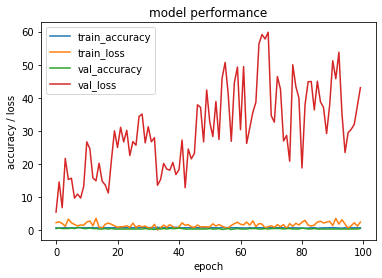

   epoch  accuracy      loss  val_accuracy  val_loss
8      8  0.815385  1.668918      0.857143  9.764569


In [ ]:
n_splits = 10
kf =  StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 666)
i = 5
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 5:
    model_filepath = '/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.h5'
    model = load_model(model_filepath)
    cross_validation_model_evaluate(
      model,  df_train_val.iloc[val_index], i, 
       )
    break
  i += 1

##SKENARIO 6

In [ ]:
k = 10
kf =  StratifiedKFold(n_splits = k, shuffle = True, random_state = 666)
i = 1
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 6:
    print('Train shape:',df_train_val.iloc[train_index].shape)
    print('val shape:', df_train_val.iloc[val_index].shape)
    datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=30, 
                                  horizontal_flip=True, 
                                  zoom_range=[0.5,1.0],)

    csv_filepath = CSVLogger('/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.log')

    model_checkpoint_callback = ModelCheckpoint(
        filepath='/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.h5',
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True)
      
    csvlogger = csv_filepath
    callbacks = []
    callbacks.append(csvlogger)
    callbacks.append(model_checkpoint_callback)

    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[train_index], 
        x_col="path", 
        y_col="label", 
        shuffle=True, 
        target_size=(224,224),
        class_mode="categorical",) 
  
    val_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[val_index], 
        x_col="path", 
        y_col="label", 
        shuffle=False, 
        target_size=(224,224),
        class_mode="categorical",)
    optimizer = Adam(learning_rate=0.0001)  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    result = model.fit(x=train_generator,validation_data=val_generator, epochs=100, callbacks=callbacks )
    break
  i += 1

Train shape: (65, 2)
val shape: (7, 2)
Found 65 validated image filenames belonging to 4 classes.
Found 7 validated image filenames belonging to 4 classes.
Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 2.6104 - accuracy: 0.7231
Epoch 1: val_accuracy improved from -inf to 0.42857, saving model to /content/drive/MyDrive/buktiUji_Skripsi/Model/_fold_6_model.h5
3/3 [==============================] - 32s 15s/step - loss: 2.6104 - accuracy: 0.7231 - val_loss: 28.9639 - val_accuracy: 0.4286
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 3.6218 - accuracy: 0.6923
Epoch 2: val_accuracy did not improve from 0.42857
3/3 [==============================] - 2s 633ms/step - loss: 3.6218 - accuracy: 0.6923 - val_loss: 47.7638 - val_accuracy: 0.2857
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 2.0103 - accuracy: 0.7692
Epoch 3: val_accuracy did not improve from 0.42857
3/3 [==============================] - 2s 964ms/step - loss: 2.0103 - ac

###EVAL

Found 8 validated image filenames belonging to 4 classes.


1/1 [==============================] - 0s 414ms/step
Predict 0       1       2       3       
Actual
0       2       0       0       0       

1       1       1       0       0       

2       1       1       0       0       

3       1       0       0       1       





Overall Statistics : 

95% CI                                                            (0.15352,0.84648)
ACC Macro                                                         0.75
ARI                                                               -0.09639
AUNP                                                              0.66667
AUNU                                                              0.66667
Bangdiwala B                                                      0.375
Bennett S                                                         0.33333
CBA                                                               0.35
CSI                                                               None
Chi-Squared                           

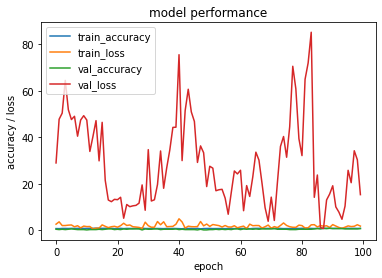

    epoch  accuracy      loss  val_accuracy  val_loss
87     87  0.769231  1.756818      0.857143  0.751488


In [ ]:
n_splits = 10
kf =  StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 666)
i = 6
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 6:
    model_filepath = '/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.h5'
    model = load_model(model_filepath)
    cross_validation_model_evaluate(
      model,  df_train_val.iloc[val_index], i, 
       )
    break
  i += 1

##SKENARIO 7

In [ ]:
k = 10
kf =  StratifiedKFold(n_splits = k, shuffle = True, random_state = 666)
i = 1
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 7:
    print('Train shape:',df_train_val.iloc[train_index].shape)
    print('val shape:', df_train_val.iloc[val_index].shape)
    datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=30, 
                                  horizontal_flip=True, 
                                  zoom_range=[0.5,1.0],)

    csv_filepath = CSVLogger('/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.log')

    model_checkpoint_callback = ModelCheckpoint(
        filepath='/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.h5',
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True)
      
    csvlogger = csv_filepath
    callbacks = []
    callbacks.append(csvlogger)
    callbacks.append(model_checkpoint_callback)

    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[train_index], 
        x_col="path", 
        y_col="label", 
        shuffle=True, 
        target_size=(224,224),
        class_mode="categorical",) 
  
    val_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[val_index], 
        x_col="path", 
        y_col="label", 
        shuffle=False, 
        target_size=(224,224),
        class_mode="categorical",)
    optimizer = Adam(learning_rate=0.0001)  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    result = model.fit(x=train_generator,validation_data=val_generator, epochs=100, callbacks=callbacks )
    break
  i += 1

Train shape: (65, 2)
val shape: (7, 2)
Found 65 validated image filenames belonging to 4 classes.
Found 7 validated image filenames belonging to 4 classes.
Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 2.1046 - accuracy: 0.7538
Epoch 1: val_accuracy improved from -inf to 0.42857, saving model to /content/drive/MyDrive/buktiUji_Skripsi/Model/_fold_7_model.h5
3/3 [==============================] - 37s 17s/step - loss: 2.1046 - accuracy: 0.7538 - val_loss: 9.3518 - val_accuracy: 0.4286
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 1.6121 - accuracy: 0.8154
Epoch 2: val_accuracy did not improve from 0.42857
3/3 [==============================] - 3s 666ms/step - loss: 1.6121 - accuracy: 0.8154 - val_loss: 37.0330 - val_accuracy: 0.1429
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 1.8181 - accuracy: 0.7692
Epoch 3: val_accuracy did not improve from 0.42857
3/3 [==============================] - 2s 485ms/step - loss: 1.8181 - acc

###EVAL

Found 8 validated image filenames belonging to 4 classes.
1/1 [==============================] - 0s 345ms/step
Predict 0       1       2       3       
Actual
0       1       0       1       0       

1       0       2       0       0       

2       0       0       2       0       

3       0       2       0       0       





Overall Statistics : 

95% CI                                                            (0.28952,0.96048)
ACC Macro                                                         0.8125
ARI                                                               0.32877
AUNP                                                              0.75
AUNU                                                              0.75
Bangdiwala B                                                      0.5625
Bennett S                                                         0.5
CBA                                                               0.41667
CSI                                                     

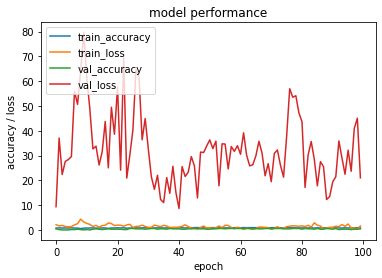

    epoch  accuracy      loss  val_accuracy   val_loss
88     88  0.876923  0.847286      0.571429  12.264671


In [ ]:
n_splits = 10
kf =  StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 666)
i = 7
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 7:
    model_filepath = '/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.h5'
    model = load_model(model_filepath)
    cross_validation_model_evaluate(
      model,  df_train_val.iloc[val_index], i, 
       )
    break
  i += 1

##SKENARIO 8

In [ ]:
k = 10
kf =  StratifiedKFold(n_splits = k, shuffle = True, random_state = 666)
i = 1
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 8:
    print('Train shape:',df_train_val.iloc[train_index].shape)
    print('val shape:', df_train_val.iloc[val_index].shape)
    datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=30, 
                                  horizontal_flip=True, 
                                  zoom_range=[0.5,1.0],)

    csv_filepath = CSVLogger('/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.log')

    model_checkpoint_callback = ModelCheckpoint(
        filepath='/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.h5',
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True)
      
    csvlogger = csv_filepath
    callbacks = []
    callbacks.append(csvlogger)
    callbacks.append(model_checkpoint_callback)

    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[train_index], 
        x_col="path", 
        y_col="label", 
        shuffle=True, 
        target_size=(224,224),
        class_mode="categorical",) 
  
    val_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[val_index], 
        x_col="path", 
        y_col="label", 
        shuffle=False, 
        target_size=(224,224),
        class_mode="categorical",)
    optimizer = Adam(learning_rate=0.0001)  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    result = model.fit(x=train_generator,validation_data=val_generator, epochs=100, callbacks=callbacks )
    break
  i += 1

Train shape: (65, 2)
val shape: (7, 2)
Found 65 validated image filenames belonging to 4 classes.
Found 7 validated image filenames belonging to 4 classes.
Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 2.3084 - accuracy: 0.7692
Epoch 1: val_accuracy improved from -inf to 0.71429, saving model to /content/drive/MyDrive/buktiUji_Skripsi/Model/_fold_8_model.h5
3/3 [==============================] - 34s 16s/step - loss: 2.3084 - accuracy: 0.7692 - val_loss: 11.1699 - val_accuracy: 0.7143
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 1.6464 - accuracy: 0.8000
Epoch 2: val_accuracy did not improve from 0.71429
3/3 [==============================] - 2s 969ms/step - loss: 1.6464 - accuracy: 0.8000 - val_loss: 6.6765 - val_accuracy: 0.5714
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 2.3165 - accuracy: 0.7077
Epoch 3: val_accuracy did not improve from 0.71429
3/3 [==============================] - 2s 668ms/step - loss: 2.3165 - acc

###EVAL

Found 8 validated image filenames belonging to 4 classes.
1/1 [==============================] - 0s 367ms/step
Predict 0       1       2       3       
Actual
0       2       0       0       0       

1       1       1       0       0       

2       1       0       1       0       

3       0       0       0       2       





Overall Statistics : 

95% CI                                                            (0.44994,1.05006)
ACC Macro                                                         0.875
ARI                                                               0.22222
AUNP                                                              0.83333
AUNU                                                              0.83333
Bangdiwala B                                                      0.625
Bennett S                                                         0.66667
CBA                                                               0.625
CSI                                               

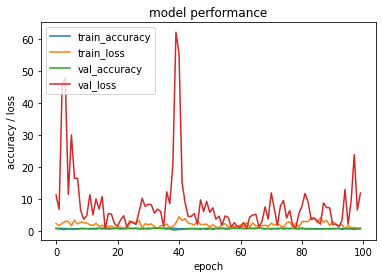

    epoch  accuracy      loss  val_accuracy  val_loss
60     60  0.753846  1.864048      0.857143  1.205076


In [ ]:
n_splits = 10
kf =  StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 666)
i = 8
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 8:
    model_filepath = '/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.h5'
    model = load_model(model_filepath)
    cross_validation_model_evaluate(
      model,  df_train_val.iloc[val_index], i, 
       )
    break
  i += 1

##SKENARIO 9

In [ ]:
k = 10
kf =  StratifiedKFold(n_splits = k, shuffle = True, random_state = 666)
i = 1
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 9:
    print('Train shape:',df_train_val.iloc[train_index].shape)
    print('val shape:', df_train_val.iloc[val_index].shape)
    datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=30, 
                                  horizontal_flip=True, 
                                  zoom_range=[0.5,1.0],)

    csv_filepath = CSVLogger('/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.log')

    model_checkpoint_callback = ModelCheckpoint(
        filepath='/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.h5',
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True)
      
    csvlogger = csv_filepath
    callbacks = []
    callbacks.append(csvlogger)
    callbacks.append(model_checkpoint_callback)

    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[train_index], 
        x_col="path", 
        y_col="label", 
        shuffle=True, 
        target_size=(224,224),
        class_mode="categorical",) 
  
    val_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[val_index], 
        x_col="path", 
        y_col="label", 
        shuffle=False, 
        target_size=(224,224),
        class_mode="categorical",)
    optimizer = Adam(learning_rate=0.0001)  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    result = model.fit(x=train_generator,validation_data=val_generator, epochs=100, callbacks=callbacks )
    break
  i += 1

Train shape: (65, 2)
val shape: (7, 2)
Found 65 validated image filenames belonging to 4 classes.
Found 7 validated image filenames belonging to 4 classes.
Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 3.6294 - accuracy: 0.6154
Epoch 1: val_accuracy improved from -inf to 0.57143, saving model to /content/drive/MyDrive/buktiUji_Skripsi/Model/_fold_9_model.h5
3/3 [==============================] - 32s 14s/step - loss: 3.6294 - accuracy: 0.6154 - val_loss: 2.2945 - val_accuracy: 0.5714
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.9806 - accuracy: 0.8462
Epoch 2: val_accuracy improved from 0.57143 to 0.71429, saving model to /content/drive/MyDrive/buktiUji_Skripsi/Model/_fold_9_model.h5
3/3 [==============================] - 10s 5s/step - loss: 0.9806 - accuracy: 0.8462 - val_loss: 11.3581 - val_accuracy: 0.7143
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 1.5086 - accuracy: 0.7692
Epoch 3: val_accuracy did not improve from

###EVAL

Found 8 validated image filenames belonging to 4 classes.
1/1 [==============================] - 0s 413ms/step
Predict 0       1       2       3       
Actual
0       2       0       0       0       

1       1       1       0       0       

2       1       0       0       1       

3       0       0       0       2       





Overall Statistics : 

95% CI                                                            (0.28952,0.96048)
ACC Macro                                                         0.8125
ARI                                                               0.13699
AUNP                                                              0.75
AUNU                                                              0.75
Bangdiwala B                                                      0.5625
Bennett S                                                         0.5
CBA                                                               0.41667
CSI                                                     

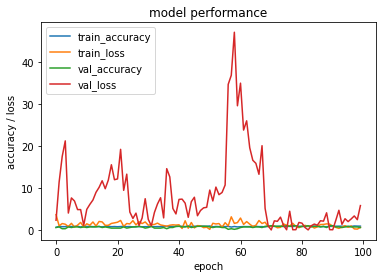

    epoch  accuracy      loss  val_accuracy  val_loss
70     70  0.846154  0.937355           1.0  0.000019


In [ ]:
n_splits = 10
kf =  StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 666)
i = 9
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 9:
    model_filepath = '/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.h5'
    model = load_model(model_filepath)
    cross_validation_model_evaluate(
      model,  df_train_val.iloc[val_index], i, 
       )
    break
  i += 1

##SKENARIO 10

In [ ]:
k = 10
kf =  StratifiedKFold(n_splits = k, shuffle = True, random_state = 666)
i = 1
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 10:
    print('Train shape:',df_train_val.iloc[train_index].shape)
    print('val shape:', df_train_val.iloc[val_index].shape)
    datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=30, 
                                  horizontal_flip=True, 
                                  zoom_range=[0.5,1.0],)

    csv_filepath = CSVLogger('/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.log')

    model_checkpoint_callback = ModelCheckpoint(
        filepath='/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.h5',
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        verbose=1,
        save_best_only=True)
      
    csvlogger = csv_filepath
    callbacks = []
    callbacks.append(csvlogger)
    callbacks.append(model_checkpoint_callback)

    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[train_index], 
        x_col="path", 
        y_col="label", 
        shuffle=True, 
        target_size=(224,224),
        class_mode="categorical",) 
  
    val_generator = datagen.flow_from_dataframe(
        dataframe=df_train_val.iloc[val_index], 
        x_col="path", 
        y_col="label", 
        shuffle=False, 
        target_size=(224,224),
        class_mode="categorical",)
    optimizer = Adam(learning_rate=0.0001)  
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    result = model.fit(x=train_generator,validation_data=val_generator, epochs=100, callbacks=callbacks )
    break
  i += 1

Train shape: (65, 2)
val shape: (7, 2)
Found 65 validated image filenames belonging to 4 classes.
Found 7 validated image filenames belonging to 4 classes.
Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 1.0841 - accuracy: 0.8308
Epoch 1: val_accuracy improved from -inf to 0.57143, saving model to /content/drive/MyDrive/buktiUji_Skripsi/Model/_fold_10_model.h5
3/3 [==============================] - 23s 11s/step - loss: 1.0841 - accuracy: 0.8308 - val_loss: 36.7455 - val_accuracy: 0.5714
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 1.5040 - accuracy: 0.7538
Epoch 2: val_accuracy did not improve from 0.57143
3/3 [==============================] - 3s 677ms/step - loss: 1.5040 - accuracy: 0.7538 - val_loss: 23.2630 - val_accuracy: 0.4286
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 1.0794 - accuracy: 0.8154
Epoch 3: val_accuracy did not improve from 0.57143
3/3 [==============================] - 2s 668ms/step - loss: 1.0794 - a

###EVAL

Found 8 validated image filenames belonging to 4 classes.
1/1 [==============================] - 0s 434ms/step
Predict 0       1       2       3       
Actual
0       2       0       0       0       

1       1       1       0       0       

2       0       0       1       1       

3       0       0       0       2       





Overall Statistics : 

95% CI                                                            (0.44994,1.05006)
ACC Macro                                                         0.875
ARI                                                               0.27586
AUNP                                                              0.83333
AUNU                                                              0.83333
Bangdiwala B                                                      0.625
Bennett S                                                         0.66667
CBA                                                               0.58333
CSI                                             

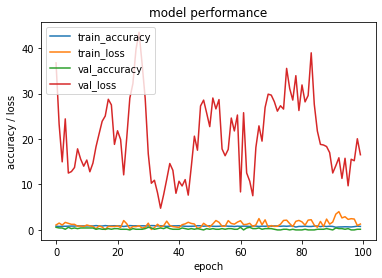

    epoch  accuracy      loss  val_accuracy  val_loss
60     60  0.784615  2.021995      0.571429  8.359302


In [ ]:
n_splits = 10
kf =  StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 666)
i = 10
for train_index, val_index in kf.split(df_train_val['path'], df_train_val['label']):
  if i == 10:
    model_filepath = '/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + str(i) + '_model.h5'
    model = load_model(model_filepath)
    cross_validation_model_evaluate(
      model,  df_train_val.iloc[val_index], i, 
       )
    break
  i += 1

#HASIL DARI SELURUH SKENARIO NILAI K

In [ ]:
df_result_experiment = pd.DataFrame()
for i in range(1, 11):
  df_result = pd.read_csv('/content/drive/MyDrive/buktiUji_Skripsi/' +"Model/" + '_fold_' + str(i) + '_model.log')
  df_result = df_result[(df_result.val_accuracy == df_result.val_accuracy.max())]
  df_result = df_result[(df_result.val_loss== df_result.val_loss.min())]
  df_result_experiment = pd.concat([df_result_experiment, df_result])


df_result_experiment = df_result_experiment.reset_index(drop=True)
df_result_experiment.index += 1
pd.set_option('display.max_rows', df_result_experiment.shape[0]+1)
df_average =df_result_experiment.iloc[:].mean(axis=0)
df_result_experiment.loc[11] = df_average
df_result_experiment = df_result_experiment.style.background_gradient(cmap='Accent', subset=df_result_experiment.index[-1])
df_result_experiment

,epoch,accuracy,loss,val_accuracy,val_loss
1,99.000000,0.953125,0.722035,0.750000,63.736454
2,69.000000,0.937500,0.532490,0.875000,0.390712
3,0.000000,0.907692,1.510977,0.857143,5.927969
4,96.000000,0.784615,1.455903,0.857143,2.806266
5,8.000000,0.815385,1.668918,0.857143,9.764569
6,87.000000,0.769231,1.756818,0.857143,0.751488
7,88.000000,0.876923,0.847286,0.571429,12.264671
8,60.000000,0.753846,1.864048,0.857143,1.205076
9,70.000000,0.846154,0.937355,1.000000,0.000019
10,60.000000,0.784615,2.021995,0.571429,8.359302


#PENGUJIAN UNSEEN DATA

##SKENARIO 1

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255,)
test_generator = val_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=data_dir,
        x_col="path",
        y_col="label",
        shuffle=False,
        target_size=image_size,
        class_mode="categorical", )
model_filepath =  '/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + '1' + '_model.h5'
model = load_model(model_filepath)
Y_pred = model.predict(test_generator,)
y_pred = np.argmax(Y_pred, axis=1)
y_test = test_generator.classes
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred) 
print(cm)

Found 8 validated image filenames belonging to 4 classes.
1/1 [==============================] - 0s 318ms/step
Predict 0       1       2       3       
Actual
0       0       0       1       1       

1       0       1       0       1       

2       0       1       0       0       

3       0       0       0       3       





Overall Statistics : 

95% CI                                                            (0.15352,0.84648)
ACC Macro                                                         0.75
ARI                                                               0.1716
AUNP                                                              0.64524
AUNU                                                              0.59881
Bangdiwala B                                                      0.5
Bennett S                                                         0.33333
CBA                                                               0.275
CSI                                                   

##SKENARIO 2

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255,)
test_generator = val_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=data_dir,
        x_col="path",
        y_col="label",
        shuffle=False,
        target_size=image_size,
        class_mode="categorical", )
model_filepath =  '/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + '2' + '_model.h5'
model = load_model(model_filepath)
Y_pred = model.predict(test_generator,)
y_pred = np.argmax(Y_pred, axis=1)
y_test = test_generator.classes
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred) 
print(cm)

Found 8 validated image filenames belonging to 4 classes.
1/1 [==============================] - 0s 307ms/step
Predict 0       1       2       3       
Actual
0       2       0       0       0       

1       0       1       0       1       

2       0       0       0       1       

3       0       0       0       3       





Overall Statistics : 

95% CI                                                            (0.44994,1.05006)
ACC Macro                                                         0.875
ARI                                                               0.33728
AUNP                                                              0.8
AUNU                                                              0.7625
Bangdiwala B                                                      0.66667
Bennett S                                                         0.66667
CBA                                                               0.525
CSI                                                  

##SKENARIO 3

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255,)
test_generator = val_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=data_dir,
        x_col="path",
        y_col="label",
        shuffle=False,
        target_size=image_size,
        class_mode="categorical", )
model_filepath =  '/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + '3' + '_model.h5'
model = load_model(model_filepath)
Y_pred = model.predict(test_generator,)
y_pred = np.argmax(Y_pred, axis=1)
y_test = test_generator.classes
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred) 
print(cm)

Found 8 validated image filenames belonging to 4 classes.
1/1 [==============================] - 0s 318ms/step
Predict 0       1       2       3       
Actual
0       0       1       0       1       

1       0       2       0       0       

2       0       0       0       1       

3       0       0       0       3       





Overall Statistics : 

95% CI                                                            (0.28952,0.96048)
ACC Macro                                                         0.8125
ARI                                                               0.25134
AUNP                                                              0.71667
AUNU                                                              0.67917
Bangdiwala B                                                      0.61905
Bennett S                                                         0.5
CBA                                                               0.31667
CSI                                              

##SKENARIO 4

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255,)
test_generator = val_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=data_dir,
        x_col="path",
        y_col="label",
        shuffle=False,
        target_size=image_size,
        class_mode="categorical", )
model_filepath =  '/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + '4' + '_model.h5'
model = load_model(model_filepath)
Y_pred = model.predict(test_generator,)
y_pred = np.argmax(Y_pred, axis=1)
y_test = test_generator.classes
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred) 
print(cm)

Found 8 validated image filenames belonging to 4 classes.
1/1 [==============================] - 0s 318ms/step
Predict 0       1       2       3       
Actual
0       0       1       1       0       

1       2       0       0       0       

2       1       0       0       0       

3       0       0       0       3       





Overall Statistics : 

95% CI                                                            (0.03952,0.71048)
ACC Macro                                                         0.6875
ARI                                                               0.66129
AUNP                                                              0.59524
AUNU                                                              0.52381
Bangdiwala B                                                      0.5
Bennett S                                                         0.16667
CBA                                                               0.25
CSI                                                 

##SKENARIO 5

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255,)
test_generator = val_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=data_dir,
        x_col="path",
        y_col="label",
        shuffle=False,
        target_size=image_size,
        class_mode="categorical", )
model_filepath =  '/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + '5' + '_model.h5'
model = load_model(model_filepath)
Y_pred = model.predict(test_generator,)
y_pred = np.argmax(Y_pred, axis=1)
y_test = test_generator.classes
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred) 
print(cm)

Found 8 validated image filenames belonging to 4 classes.
1/1 [==============================] - 0s 321ms/step
Predict 0       1       2       3       
Actual
0       0       1       1       0       

1       0       2       0       0       

2       0       1       0       0       

3       0       3       0       0       





Overall Statistics : 

95% CI                                                            (-0.05006,0.55006)
ACC Macro                                                         0.625
ARI                                                               0.02703
AUNP                                                              0.5119
AUNU                                                              0.50298
Bangdiwala B                                                      0.26667
Bennett S                                                         0.0
CBA                                                               0.07143
CSI                                               

##SKENARIO 6

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255,)
test_generator = val_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=data_dir,
        x_col="path",
        y_col="label",
        shuffle=False,
        target_size=image_size,
        class_mode="categorical", )
model_filepath =  '/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + '6' + '_model.h5'
model = load_model(model_filepath)
Y_pred = model.predict(test_generator,)
y_pred = np.argmax(Y_pred, axis=1)
y_test = test_generator.classes
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred) 
print(cm)

Found 8 validated image filenames belonging to 4 classes.
1/1 [==============================] - 0s 307ms/step
Predict 0       1       2       3       
Actual
0       0       2       0       0       

1       1       1       0       0       

2       0       1       0       0       

3       1       1       0       1       





Overall Statistics : 

95% CI                                                            (-0.05006,0.55006)
ACC Macro                                                         0.625
ARI                                                               -0.15976
AUNP                                                              0.5
AUNU                                                              0.47917
Bangdiwala B                                                      0.11765
Bennett S                                                         0.0
CBA                                                               0.13333
CSI                                                 

##SKENARIO 7

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255,)
test_generator = val_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=data_dir,
        x_col="path",
        y_col="label",
        shuffle=False,
        target_size=image_size,
        class_mode="categorical", )
model_filepath =  '/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + '7' + '_model.h5'
model = load_model(model_filepath)
Y_pred = model.predict(test_generator,)
y_pred = np.argmax(Y_pred, axis=1)
y_test = test_generator.classes
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred) 
print(cm)

Found 8 validated image filenames belonging to 4 classes.
1/1 [==============================] - 0s 313ms/step
Predict 0       1       2       3       
Actual
0       0       2       0       0       

1       0       1       1       0       

2       0       1       0       0       

3       0       1       2       0       





Overall Statistics : 

95% CI                                                            (-0.10418,0.35418)
ACC Macro                                                         0.5625
ARI                                                               -0.04813
AUNP                                                              0.45238
AUNU                                                              0.4256
Bangdiwala B                                                      0.07692
Bennett S                                                         -0.16667
CBA                                                               0.05
CSI                                           

##SKENARIO 8

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255,)
test_generator = val_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=data_dir,
        x_col="path",
        y_col="label",
        shuffle=False,
        target_size=image_size,
        class_mode="categorical", )
model_filepath =  '/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + '8' + '_model.h5'
model = load_model(model_filepath)
Y_pred = model.predict(test_generator,)
y_pred = np.argmax(Y_pred, axis=1)
y_test = test_generator.classes
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred) 
print(cm)

Found 8 validated image filenames belonging to 4 classes.
1/1 [==============================] - 0s 339ms/step
Predict 0       1       2       3       
Actual
0       0       2       0       0       

1       0       1       0       1       

2       0       0       0       1       

3       0       0       0       3       





Overall Statistics : 

95% CI                                                            (0.15352,0.84648)
ACC Macro                                                         0.75
ARI                                                               0.25134
AUNP                                                              0.63333
AUNU                                                              0.59583
Bangdiwala B                                                      0.47619
Bennett S                                                         0.33333
CBA                                                               0.23333
CSI                                            

##SKENARIO 9

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255,)
test_generator = val_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=data_dir,
        x_col="path",
        y_col="label",
        shuffle=False,
        target_size=image_size,
        class_mode="categorical", )
model_filepath =  '/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + '9' + '_model.h5'
model = load_model(model_filepath)
Y_pred = model.predict(test_generator,)
y_pred = np.argmax(Y_pred, axis=1)
y_test = test_generator.classes
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred) 
print(cm)

Found 8 validated image filenames belonging to 4 classes.
1/1 [==============================] - 5s 5s/step
Predict 0       1       2       3       
Actual
0       0       0       0       2       

1       1       0       0       1       

2       0       0       0       1       

3       0       0       0       3       





Overall Statistics : 

95% CI                                                            (0.03952,0.71048)
ACC Macro                                                         0.6875
ARI                                                               0.02703
AUNP                                                              0.51667
AUNU                                                              0.50417
Bangdiwala B                                                      0.3913
Bennett S                                                         0.16667
CBA                                                               0.10714
CSI                                              

##SKENARO 10

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255,)
test_generator = val_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=data_dir,
        x_col="path",
        y_col="label",
        shuffle=False,
        target_size=image_size,
        class_mode="categorical", )
model_filepath =  '/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + '10' + '_model.h5'
model = load_model(model_filepath)
Y_pred = model.predict(test_generator,)
y_pred = np.argmax(Y_pred, axis=1)
y_test = test_generator.classes
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred) 
print(cm)

Found 8 validated image filenames belonging to 4 classes.
1/1 [==============================] - 5s 5s/step
Predict 0       1       2       3       
Actual
0       0       0       0       2       

1       1       0       0       1       

2       0       0       0       1       

3       0       0       0       3       





Overall Statistics : 

95% CI                                                            (0.03952,0.71048)
ACC Macro                                                         0.6875
ARI                                                               0.02703
AUNP                                                              0.51667
AUNU                                                              0.50417
Bangdiwala B                                                      0.3913
Bennett S                                                         0.16667
CBA                                                               0.10714
CSI                                              

#UJI COBA KLASIFIKASI KELAS 1

1/1 [==============================] - 3s 3s/step
prediction is chickenpox


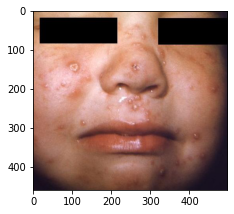

In [ ]:
model_filepath =  '/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + '2' + '_model.h5'
model = load_model(model_filepath)

def plot_img_array(path):
  img = image.load_img(path)
  plt.grid(False)
  plt.imshow(img)


def predict_image(model, google_drive=None):
  if google_drive == None:
    uploaded = files.upload()
    for fn in uploaded.keys():
      path = '/content/' + fn
  else:
    path = google_drive
  image = tf.keras.preprocessing.image.load_img(path,  
                                                  target_size=image_size, )
  input_arr = tf.keras.preprocessing.image.img_to_array(image) / 255
  input_arr = np.array([input_arr]) 
  classes = model.predict(input_arr)
  
  rows = 10
  cols = 2
  plt.figure(figsize=(2*4*cols, 4*rows))  
  index = 1
  plt.subplot(rows, cols * 2, index*2 + 1)
  plot_img_array(path)
  keyList = list(class_names.keys())
  valList = list(class_names.values())
  position = valList.index(np.argmax(classes)) 
  prediction = 'prediction is ' + str(keyList[position])
  print(prediction) 
  if google_drive == None:
    os.remove(path)

def plot_predict_value_array(predictions_array):
  plt.grid(False)
  plt.ylim([0, 1])

predict_image(model, '/content/drive/MyDrive/buktiUji_Skripsi/Dataset/chickenpox/chickenpox (313).jpg')

#UJI COBA KLASIFIKASI KELAS 2

1/1 [==============================] - 2s 2s/step
prediction is chickenpox


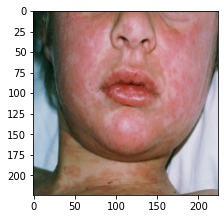

In [ ]:
model_filepath =  '/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + '2' + '_model.h5'
model = load_model(model_filepath)

def plot_img_array(path):
  img = image.load_img(path)
  plt.grid(False)
  plt.imshow(img)


def predict_image(model, google_drive=None):
  if google_drive == None:
    uploaded = files.upload()
    for fn in uploaded.keys():
      path = '/content/' + fn
  else:
    path = google_drive
  image = tf.keras.preprocessing.image.load_img(path,  
                                                  target_size=image_size, )
  input_arr = tf.keras.preprocessing.image.img_to_array(image) / 255
  input_arr = np.array([input_arr]) 
  classes = model.predict(input_arr)
  
  rows = 10
  cols = 2
  plt.figure(figsize=(2*4*cols, 4*rows))  
  index = 1
  plt.subplot(rows, cols * 2, index*2 + 1)
  plot_img_array(path)
  keyList = list(class_names.keys())
  valList = list(class_names.values())
  position = valList.index(np.argmax(classes)) 
  prediction = 'prediction is ' + str(keyList[position])
  print(prediction) 
  if google_drive == None:
    os.remove(path)

def plot_predict_value_array(predictions_array):
  plt.grid(False)
  plt.ylim([0, 1])

predict_image(model, '/content/drive/MyDrive/buktiUji_Skripsi/Dataset/measles/measles (258).jpg')

#UJI COBA KLASIFIKASI KELAS 3

1/1 [==============================] - 1s 1s/step
prediction is chickenpox


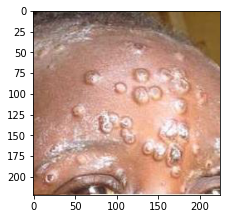

In [ ]:
model_filepath =  '/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + '2' + '_model.h5'
model = load_model(model_filepath)

def plot_img_array(path):
  img = image.load_img(path)
  plt.grid(False)
  plt.imshow(img)


def predict_image(model, google_drive=None):
  if google_drive == None:
    uploaded = files.upload()
    for fn in uploaded.keys():
      path = '/content/' + fn
  else:
    path = google_drive
  image = tf.keras.preprocessing.image.load_img(path,  
                                                  target_size=image_size, )
  input_arr = tf.keras.preprocessing.image.img_to_array(image) / 255
  input_arr = np.array([input_arr]) 
  classes = model.predict(input_arr)
  
  rows = 10
  cols = 2
  plt.figure(figsize=(2*4*cols, 4*rows))  
  index = 1
  plt.subplot(rows, cols * 2, index*2 + 1)
  plot_img_array(path)
  keyList = list(class_names.keys())
  valList = list(class_names.values())
  position = valList.index(np.argmax(classes)) 
  prediction = 'prediction is ' + str(keyList[position])
  print(prediction) 
  if google_drive == None:
    os.remove(path)

def plot_predict_value_array(predictions_array):
  plt.grid(False)
  plt.ylim([0, 1])

predict_image(model, '/content/drive/MyDrive/buktiUji_Skripsi/Dataset/monkeypox/monkeypox (195).jpg')

#UJI COBA KLASIFIKASI KELAS 4

1/1 [==============================] - 1s 1s/step
prediction is normal


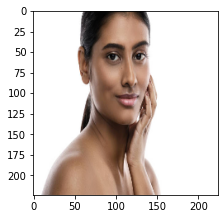

In [ ]:
model_filepath =  '/content/drive/MyDrive/buktiUji_Skripsi/' + "Model/" + '_fold_' + '2' + '_model.h5'
model = load_model(model_filepath)

def plot_img_array(path):
  img = image.load_img(path)
  plt.grid(False)
  plt.imshow(img)


def predict_image(model, google_drive=None):
  if google_drive == None:
    uploaded = files.upload()
    for fn in uploaded.keys():
      path = '/content/' + fn
  else:
    path = google_drive
  image = tf.keras.preprocessing.image.load_img(path,  
                                                  target_size=image_size, )
  input_arr = tf.keras.preprocessing.image.img_to_array(image) / 255
  input_arr = np.array([input_arr]) 
  classes = model.predict(input_arr)
  
  rows = 10
  cols = 2
  plt.figure(figsize=(2*4*cols, 4*rows))  
  index = 1
  plt.subplot(rows, cols * 2, index*2 + 1)
  plot_img_array(path)
  keyList = list(class_names.keys())
  valList = list(class_names.values())
  position = valList.index(np.argmax(classes)) 
  prediction = 'prediction is ' + str(keyList[position])
  print(prediction) 
  if google_drive == None:
    os.remove(path)

def plot_predict_value_array(predictions_array):
  plt.grid(False)
  plt.ylim([0, 1])

predict_image(model, '/content/drive/MyDrive/buktiUji_Skripsi/Dataset/normal/normal (27).jpg')